# Optimization study notebook

### Data exploration

The first step of any analysis is to understand what we are searching for. In our analysis we aim to measure the central exclusive di-lepton production, $pp\to p\oplus \ell\ell \oplus p$ process with $\ell\in\{ e,\mu \} $. Feinman diagram of this process are shown bellow: 

<img src="img/diagrams.png" alt="Feinmann diagrams" style="width: 700px;"/>

Where in our case, we will consider only electrons and muons. 

---
The measurement using 2016 data was published in [JHEP07(2018)153](https://arxiv.org/abs/1803.04496). This is the first time the 2017 data will be used to measure the central exclusive di-lepton production process at higher precision.



---
<b>Remark</b>: Exclusive production of $\tau$ leptons was not included in [JHEP07(2018)153](https://arxiv.org/abs/1803.04496) since $\tau$-leptons differ from electrons and muons by their relatively short lifetime ($c\tau_0=87\mu m$) and are observed only via their decay products. The main challenge with measuring $\tau$s is elusive neutrinos (which escape detection). Hence measurement of the momentum of $\tau$-lepton is tricky. Yet, it is possible because the opening angle between two daughter particles boosted with [lorentz factor](https://en.wikipedia.org/wiki/Lorentz_factor) $\gamma$ is given by $\theta ~\sim 2/\gamma$. With a large enough boost, the opening angle became collinear, and neutrino 4-momentum can be measured.

To understand the process better, we will explore the final state signature. As we mentioned [earlier](https://twiki.cern.ch/twiki/bin/view/CMS/SWGuideCMSDataAnalysisSchoolCERN2020TaggedProtonsLongExercise#TASK_3_Optimization_study), samples are stored in the `h5py` data format, which can be easily accessed with Jupyter notebook. 


**Install packages**: When running for the **first time**, uncomment these lines, download the recent packages, and restart the kernel

In [ ]:
#!python3 -m pip install --user uproot mplhep
#!python3 -m pip install --upgrade --user awkward

In [ ]:
#!python3 -m pip show uproot awkward mplhep

In [2]:
#start with standard python imports
#!pip install --user mplhep #enable this line if the import of mplhep fails
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import mplhep as hep
from matplotlib.colors import LogNorm

In [3]:
#to make the plots in CMS style execute this line
plt.style.use([hep.style.ROOT, hep.style.firamath])
plt.style.use(hep.style.CMS)

In [1]:
#Execute this line if running on SWAN, otherwise update the path to the data files:
PATH='/eos/home-c/cmsdas/2023/long-ex-dilep/h5py'
#PATH='output'

## Loading the data (signal)

We will load `h5py` files of the simulated signal events. Note that three different central exclusive di-lepton production processes are considered: exclusive, semi-exclusive, and inclusive (see Figure 1). We will load the files and convert them to pandas datafrme. Let's explore the differences between the processes.

### Dataformat:

We will use the following code `GetData(filename.h5)` to read the `h5` file and convert the data to pandas dataframe.

In [4]:
def GetData(filename):
    
    """ opens a summary file and converts it to a pandas dataframe """
    
    with h5py.File(filename, 'r') as f:
        dset = f['protons']
        dset_columns = f['columns']
        columns = list( dset_columns )
        columns_str = [ item.decode("utf-8") for item in columns ]
        return pd.DataFrame( dset, columns=columns_str )
    
    return pd.DataFrame()

In [5]:
#load the signal/background samples into the dataframes (takes some time)
df_signal_excl = GetData(PATH+'/output-GGToMuMu_Elastic_v0.h5')
df_background = GetData(PATH+'/output-MC13TeV_DYToLL50toInf_MLM_v0.h5')

In [6]:
#Load the data samples into the dataframes (takes some time)
df_data={}
eras=['B']
#eras=['A', B','C','D'] #uncooment to process all data
for x in eras:
    df_data[x] = GetData(PATH+'/output-UL2018{}-Mu.h5'.format(x))
    df_data[x]['era']=x
    print('output-UL2018{}-Mu shape = {}'.format(x,df_data[x].shape))

#combine all into a single one
df_data=pd.concat([df_data[x] for x in eras])

output-UL2018B-Mu shape = (788322, 21)


### Exploring the data files

Similarly to what we did with ROOT files in the short exercise, let's look at the info we have in the dataframes:

In [7]:
def PrintInfoFromDF(df):
    print('Print all branches:')
    print(df.keys())
    print('Size of the data is ',df.shape)

In [8]:
PrintInfoFromDF(df_signal_excl)
PrintInfoFromDF(df_data)

Print all branches:
Index(['Run', 'EventNum', 'MultiRP', 'Arm', 'RPId1', 'Xi', 'T', 'ThX', 'ThY',
       'Lep0Pt', 'Lep0Eta', 'Lep0Phi', 'Lep1Pt', 'Lep1Eta', 'Lep1Phi',
       'InvMass', 'PV_ndof', 'Acopl', 'XiMuMuPlus', 'XiMuMuMinus'],
      dtype='object')
Size of the data is  (308339, 20)
Print all branches:
Index(['Run', 'EventNum', 'MultiRP', 'Arm', 'RPId1', 'Xi', 'T', 'ThX', 'ThY',
       'Lep0Pt', 'Lep0Eta', 'Lep0Phi', 'Lep1Pt', 'Lep1Eta', 'Lep1Phi',
       'InvMass', 'PV_ndof', 'Acopl', 'XiMuMuPlus', 'XiMuMuMinus', 'era'],
      dtype='object')
Size of the data is  (788322, 21)


As you can see, we have 38 different columns and 212744 raws in the file (each raw corresponds to a different event). In data we have added an extra column to flag which data-taking era is the event comming from.

**TASK A**

Look at distributions of different kinematic variables (among different processes) and try to see if you observe any difference... The code below `PlotFromDF(variable, dataframes, labels)` will plot normalized shapes of selected variables. 


In [10]:
def PlotFromDF(variable, xmin, xmax, nbins, dataframes, _labels, ax, log=False):
    bins = np.linspace(xmin,xmax,nbins)
    data=[]; labels=[]
    for df, label in zip(dataframes, _labels):
        h, _ = np.histogram(df[variable], bins,density=True)
        data.append(h)
        labels.append(label)
    hep.histplot(data, bins, ax=ax, label=labels)
    hep.cms.label(llabel="Preliminary", rlabel="CMSvDAS 2023", ax=ax)
    ax.legend(); 
    ax.set(xlabel=variable, ylabel='p.d.f.')
    if log: plt.yscale("log")
    plt.savefig(variable+'.png')  

In the following example, we will plot the di-lepton [acoplanarity](https://en.wikipedia.org/wiki/Acoplanarity) defined by:
$$A = 1 - |\Delta\phi(\mu,\mu)|/\pi$$

In the exclusive events, due to absence of additional radiation, both leptons expected to be produced back-to-back, or with $\Delta\phi(\mu,\mu)\sim\pi$. 

In [11]:
# we will be plotting MC prediction with the data, where the data is mostly populated with background events
procc = [df_signal_excl,df_background,df_data]
labels = ['Exclusive dilep','inclusive Z','data']

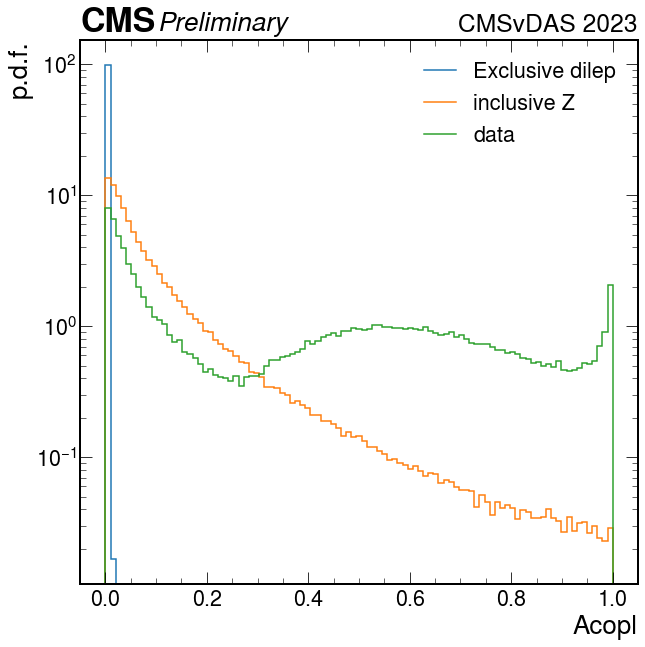

In [12]:
f, ax = plt.subplots()
PlotFromDF('Acopl',0,1,100,procc,labels, ax, log=True)

Next importants variables are the mass and the number of degrees of freedom of primary vertex (which is correlated to the number of tracks associated to the primary vertex)

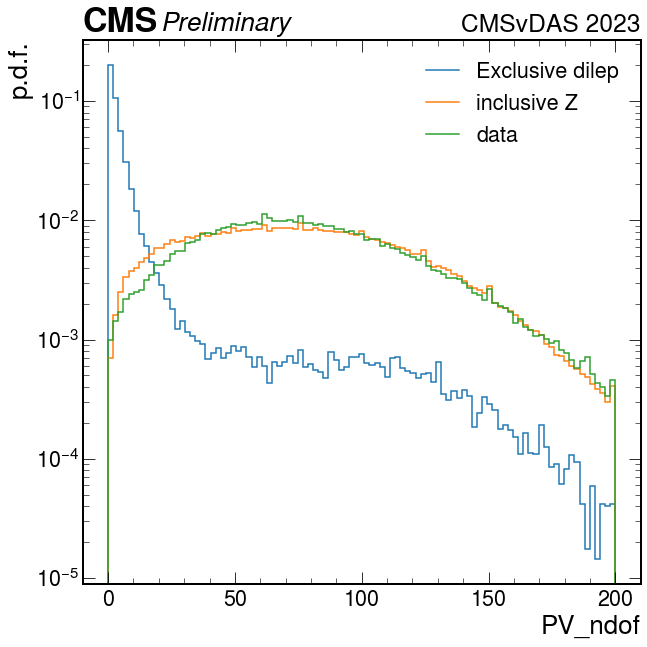

In [13]:
f, ax = plt.subplots()
PlotFromDF('PV_ndof',0,200,100,procc,labels, ax, log=True)

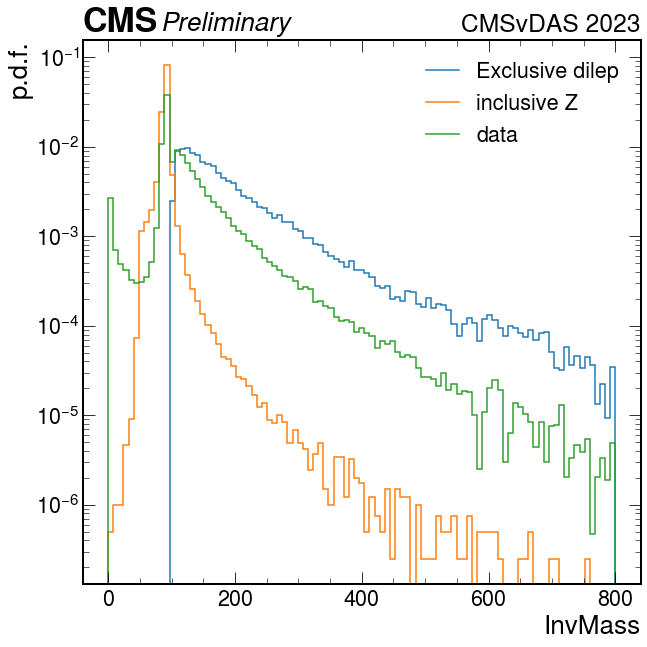

In [14]:
f, ax = plt.subplots()
PlotFromDF('InvMass',0,800,100,procc,labels, ax, log=True)

## Selection of the signal region

We see discrimination between our signal and the main background when plotting acoplanarity and track multiplicity variables.  It is common to define a figure of merit to choose the optimal selection cut. The simple approach is to ask: _Which cut will give us the highest_ $Z_0=\frac{s}{\sqrt{b}}$ _value_. Note, this figure of merit is valid for high background rate compared to the signal. However, a better approximation for the Poisson counting experiment, is to use $Z_0 = \sqrt{2\left( \left(s+b\right)\ln(1+\frac{s}{b})-s \right)}$ (Eq. 97 in [Eur. Phys. J. C71, 1554 (2011)](https://arxiv.org/pdf/1007.1727.pdf)), but we can stick to $\frac{s}{\sqrt{b}}$.

<b>TASK B</b>

Write a code that computes significance for different selection cuts. Since we are interested in the relative estimate of the significance, compute the signal and background cut efficiencies:
$$\varepsilon_s/\sqrt{\varepsilon_b} = \left(N_s^\text{cut}/\sqrt{N_b^\text{cut}}\right) / \left(N_s^\text{no-cut}/\sqrt{N_b^\text{no-cut}}\right) = \left(N_s^\text{cut}/N_s^\text{no-cut}\right) / \left(\sqrt{N_b^\text{cut} / N_b^\text{no-cut}}\right)$$

as a funciton of the cut.

Optimize selection for electrons and muons separately. 


In [15]:
# function that computes signal significance
def computeZ(Ns, Nb):
    return Ns/np.sqrt(Nb)

In [16]:
# function that computes event yields
def ComputeYields(signal, background, variable, cut, cut_type):
    if cut_type==-1:
        Ns = signal[signal[variable]<cut].groupby('EventNum').ngroups
        Nb = background[background[variable]<cut].groupby('EventNum').ngroups
    elif cut_type==0:
        Ns = signal[signal[variable]==cut].groupby('EventNum').ngroups
        Nb = background[background[variable]==cut].groupby('EventNum').ngroups
    elif cut_type==1:
        Ns = signal[signal[variable]>cut].groupby('EventNum').ngroups
        Nb = background[background[variable]>cut].groupby('EventNum').ngroups   
    else: Ns=0; Nb=1; print('Error: wrong _sign_')
    return Ns, Nb


In [17]:
#Relative significance for a single cut value (example for Acopl<0.09):
Nscut, Nbcut = ComputeYields(df_signal_excl,df_background,'Acopl',0.002,-1)
Nsnocut, Nbnocut = ComputeYields(df_signal_excl,df_background,'Acopl',1,-1)
sig_ratio = computeZ(Nscut, Nbcut) / computeZ(Nsnocut, Nbnocut)
print('Relative significance = ',sig_ratio)
print('Signal acceptance = ',Nscut/Nsnocut)

Relative significance =  2.14147348287063
Signal acceptance =  0.9673613841918993
